<div class="alert alert-block alert-info">

- [Import the needed libraries](#2nd-bullet)<br>
- [Import the dataset](#3rd-bullet)<br>
    
- [Filter methods](#6th-bullet)<br>
    - [Univariate variables](#7th-bullet)<br>
    - [Correlation Indices](#8th-bullet)<br>
    - [Chi-Square](#9th-bullet)<br>
- [Wrapper Methods](#10th-bullet)<br>
    - [RFE](#11th-bullet)<br>
        - [RFE Logistic Reg.](#12th-bullet)<br>
        - [RFE XGBoostClassifier.](#12th-bullet)<br>
- [Embedded Methods](#13th-bullet)<br>
    - [Lasso](#14th-bullet)<br>
- [Final Insights](#15th-bullet)<br>
    
</div>

<a class="anchor" id="2nd-bullet">

### Import the needed libraries
    
</a>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# data partition
from sklearn.model_selection import train_test_split


#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV
from xgboost import XGBClassifier

# embedded methods
from sklearn.linear_model import LassoCV 
from sklearn.feature_selection import mutual_info_regression, SelectKBest  # mutual information is a embedded method for regression problems 

# model assessment
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="3rd-bullet">

### Import the dataset
    
</a>

In [16]:
preproc_train = pd.read_csv('../Data/traindf.csv')

preproc_val = pd.read_csv('../Data/valdf.csv')

preproc_test = pd.read_csv('../Data/testdf.csv')

preproc_train.columns

Index(['Claim Injury Type', 'Age at Injury', 'Assembly Date',
       'Average Weekly Wage', 'Birth Year', 'C-2 Date', 'C-3 Date',
       'Carrier Name', 'Carrier Type', 'County of Injury', 'District Name',
       'First Hearing Date', 'IME-4 Count', 'Industry Code',
       'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
       'Agreement Reached', 'Number of Dependents', 'Accident Year',
       'Received_C2', 'Received_C3', 'Hearing_held',
       'Attorney/Representative_Y', 'COVID-19 Indicator_Y',
       'Alternative Dispute Resolution_Y', 'Gender_M', 'c2_to_c3_delta',
       'assembly_delta', 'process_efficiency', 'complexity_time',
       'processing_speed_rank', 'covid_risk_score', 'geo_risk_density',
       'injury_complexity', 'ime_severity', 'severity_score',
       'industry_wage_percentile', 'wage_to_industry_ratio', 'high_wage_risk'],
      dtype='object')

In [17]:
X_preproc_train = preproc_train.drop(columns=['Claim Injury Type'])

y_preproc_train = preproc_train[['Claim Injury Type']]

X_preproc_val =	preproc_train.drop(columns=['Claim Injury Type'])

y_preproc_val =preproc_train[['Claim Injury Type']]



In [18]:

# #passar o claim identifier para o index

# y_preproc_train_copy = y_preproc_train.copy()
# y_preproc_train.set_index('Claim Identifier', inplace=True)

# y_preproc_val.set_index('Claim Identifier', inplace=True)

# X_preproc_train.set_index('Claim Identifier', inplace=True)

# preproc_test.set_index('Claim Identifier', inplace=True)

# X_preproc_val.set_index('Claim Identifier', inplace=True)


<div class="alert alert-block alert-success">

<a class="anchor" id="5th-bullet">    
    
## Feature Selection
    
</a>
    
</div>

<a class="anchor" id="6th-bullet">

## Filter methods
    
</a>

<a class="anchor" id="7th-bullet">

### Univariate variables
    
</a>

Check if any of the numerical variables is univariate (variance is equal to 0), then drop those variables if any of those exist.

In [19]:
X_preproc_train.select_dtypes(include='object')

,Carrier Name,County of Injury,District Name
0,PROPERTY AND CASUALTY,QUEENS,NYC
1,HEALTH & HOSPITAL CORP.,BRONX,NYC
2,AMERICAN ZURICH INSURANCE CO,KINGS,NYC
3,"NORDSTROM, INC.",KINGS,NYC
4,NEW YORK BLACK CAR OPERATORS',NASSAU,NYC
...,...,...,...
459215,INDEMNITY INSURANCE CO OF,WESTCHESTER,NYC
459216,REDWOOD FIRE & CASUALTY,QUEENS,NYC
459217,UTICA MUTUAL INS CO,ERIE,BUFFALO
459218,NEW HAMPSHIRE INSURANCE CO,KINGS,NYC


In [20]:
cat_cols = ['Assembly Date', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'County of Injury', 'District Name', 'First Hearing Date' ]

num_X_preproc_train = X_preproc_train.drop(columns= cat_cols)

cat_X_preproc_train = X_preproc_train.select_dtypes(exclude=np.number).set_index(X_preproc_train.index)

num_X_preproc_val = X_preproc_val.drop(columns= cat_cols)

cat_X_preproc_val = X_preproc_val.select_dtypes(exclude=np.number).set_index(X_preproc_val.index)


In [21]:
num_X_preproc_train.var()

Age at Injury                       1.000002e+00
Average Weekly Wage                 1.000002e+00
Birth Year                          1.000002e+00
Carrier Type                        1.000002e+00
IME-4 Count                         1.000002e+00
Industry Code                       1.000002e+00
Medical Fee Region                  1.000002e+00
WCIO Cause of Injury Code           1.000002e+00
WCIO Nature of Injury Code          1.000002e+00
WCIO Part Of Body Code              1.000002e+00
Zip Code                            2.708769e+07
Agreement Reached                   4.431073e-02
Number of Dependents                1.000002e+00
Accident Year                       1.000002e+00
Received_C2                         0.000000e+00
Received_C3                         0.000000e+00
Hearing_held                        0.000000e+00
Attorney/Representative_Y           2.164144e-01
COVID-19 Indicator_Y                4.580129e-02
Alternative Dispute Resolution_Y    4.483018e-03
Gender_M            

<a class="anchor" id="8th-bullet">

### Correlation indices
    
</a>

In [22]:
# round to 1 decimal places
num_X_preproc_train = num_X_preproc_train.round(1)
def cor_heatmap(cor):
    plt.figure(figsize=(24,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.2f')
    plt.show()

In [23]:
cor_spearman = num_X_preproc_train.corr(method ='spearman')
cor_spearman

,Age at Injury,Average Weekly Wage,Birth Year,Carrier Type,IME-4 Count,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,...,complexity_time,processing_speed_rank,covid_risk_score,geo_risk_density,injury_complexity,ime_severity,severity_score,industry_wage_percentile,wage_to_industry_ratio,high_wage_risk
Age at Injury,1.000000,0.118462,-0.987896,-0.043147,0.128014,0.062756,0.010275,0.056501,0.038216,0.021592,...,0.127123,0.113570,0.015289,0.019449,0.005464,0.128014,0.085002,0.117512,0.099279,0.083355
Average Weekly Wage,0.118462,1.000000,-0.108808,-0.079759,0.553350,0.057416,0.035943,0.063267,0.104584,0.106551,...,0.554107,0.479045,-0.012056,0.041516,0.031797,0.553350,0.332488,0.986900,0.931862,0.901686
Birth Year,-0.987896,-0.108808,1.000000,0.042513,-0.123091,-0.056141,-0.007766,-0.054275,-0.028695,-0.012119,...,-0.120102,-0.104071,-0.016059,-0.016169,-0.003420,-0.123091,-0.081658,-0.107697,-0.090672,-0.075139
Carrier Type,-0.043147,-0.079759,0.042513,1.000000,-0.040417,-0.259938,0.010701,-0.053993,-0.071361,-0.035727,...,-0.042301,-0.032076,-0.093878,0.032732,-0.067470,-0.040417,-0.059140,-0.062971,-0.061070,-0.046893
IME-4 Count,0.128014,0.553350,-0.123091,-0.040417,1.000000,0.005172,0.070995,0.049273,0.095392,0.110585,...,0.994793,0.861693,-0.037092,0.073612,0.013438,1.000000,0.581438,0.546649,0.502798,0.503768
Industry Code,0.062756,0.057416,-0.056141,-0.259938,0.005172,1.000000,0.038770,0.145861,0.105580,0.012728,...,0.006533,0.001594,0.122596,0.049792,0.036410,0.005172,0.012582,0.046098,0.067985,0.050143
Medical Fee Region,0.010275,0.035943,-0.007766,0.010701,0.070995,0.038770,1.000000,-0.009451,-0.025361,-0.010371,...,0.073769,0.075414,0.005243,0.692013,-0.007242,0.070995,0.033724,0.030545,0.015030,0.010957
WCIO Cause of Injury Code,0.056501,0.063267,-0.054275,-0.053993,0.049273,0.145861,-0.009451,1.000000,0.279270,0.086187,...,0.048180,0.040595,0.599397,-0.002937,0.169237,0.049273,0.160778,0.061766,0.070096,0.066758
WCIO Nature of Injury Code,0.038216,0.104584,-0.028695,-0.071361,0.095392,0.105580,-0.025361,0.279270,1.000000,0.264075,...,0.096517,0.065532,0.517199,-0.022589,0.524072,0.095392,0.427045,0.101198,0.110685,0.104618
WCIO Part Of Body Code,0.021592,0.106551,-0.012119,-0.035727,0.110585,0.012728,-0.010371,0.086187,0.264075,1.000000,...,0.114754,0.105418,0.094958,-0.014150,0.608580,0.110585,0.526972,0.106528,0.110756,0.112617


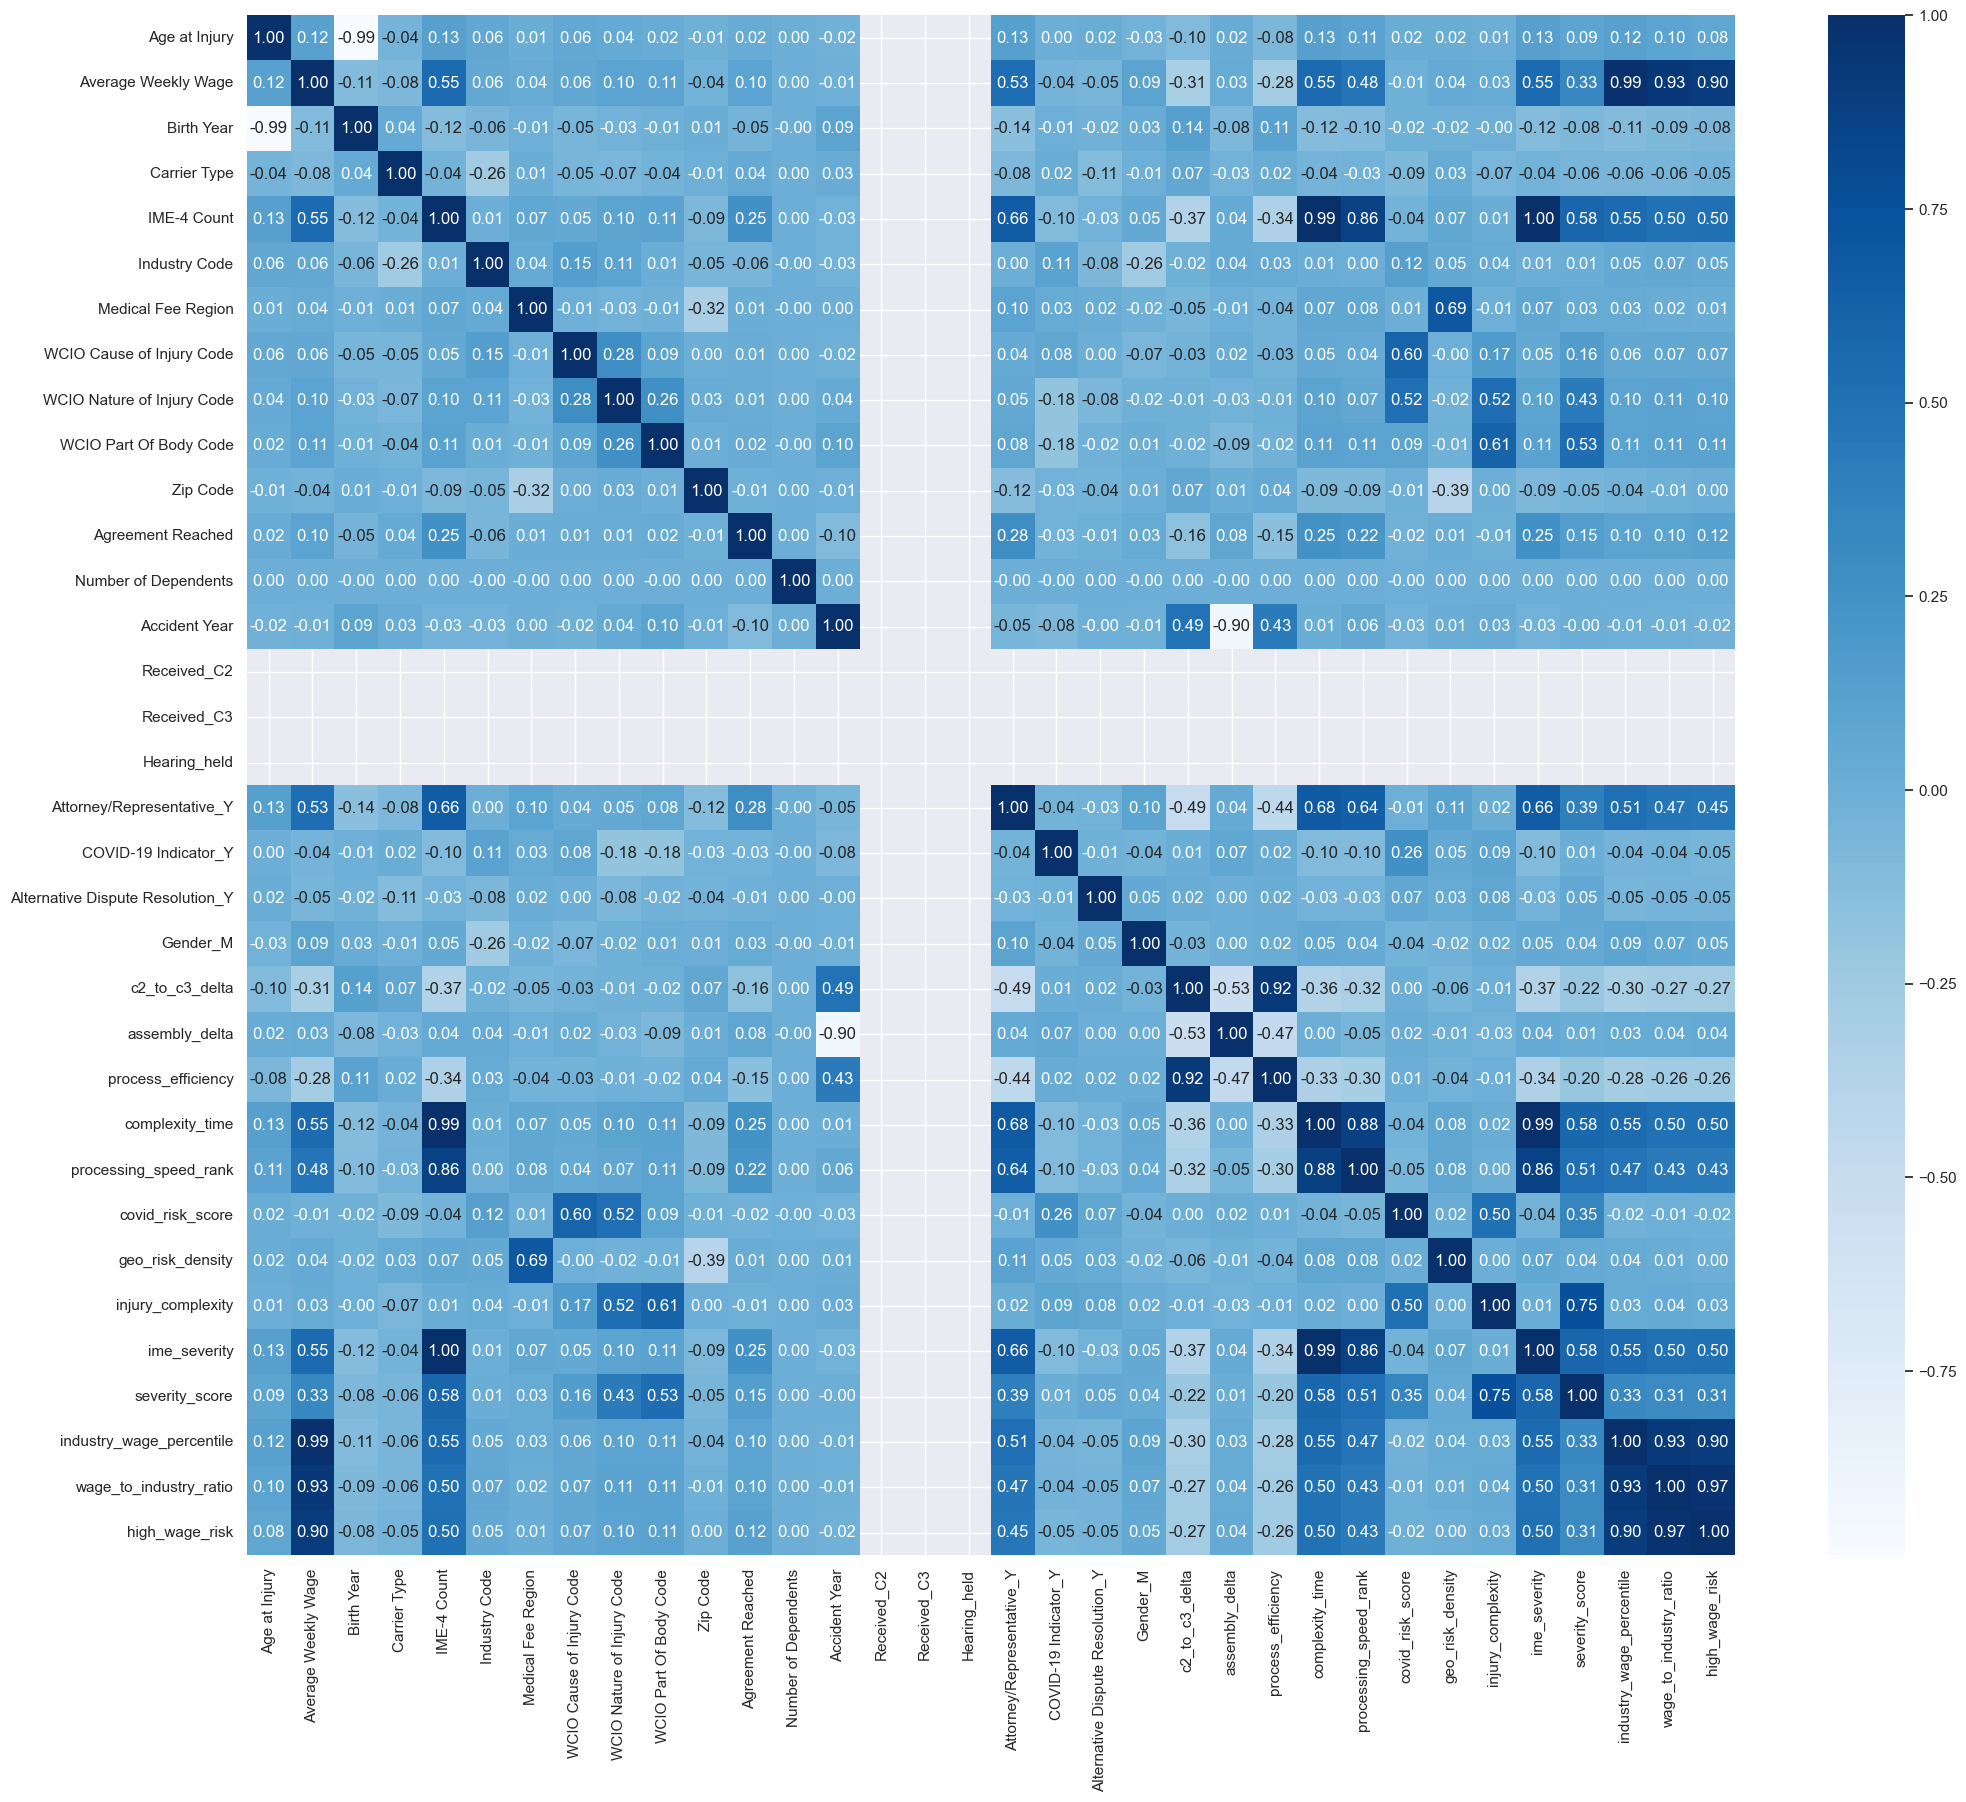

In [24]:
cor_heatmap(cor_spearman)

We will assume that the Thresholds for feature relevance is 0.2 and redundance for 0,8


<a class="anchor" id="9th-bullet">

### Chi-Square for categorical data

</a>

In [25]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [27]:
#turn into a 1D array 
y_preproc_train_woutCI = y_preproc_train.values.ravel()

for var in cat_X_preproc_train.columns:
    TestIndependence(cat_X_preproc_train[var],y_preproc_train_woutCI,var)


Carrier Name is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction


<a class="anchor" id="11th-bullet">

## Wrapper Methods
    
</a>

<a class="anchor" id="12th-bullet">

### RFE
    
</a>

In [28]:
num_X_preproc_train.columns.value_counts().sum()

34

<a class="anchor" id="13th-bullet">

#### RFE Logistic Regression

</a>

Using RFE, the objective is finding the optimal number of features to select

we will use only 4000 rows of data so rfe is faster


In [29]:
#number of features
nof_list= np.arange(1,24)            
high_score=0

#Variable to store the optimum features
nof=0           
train_f1score_list =[]
val_f1score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(num_X_preproc_train[:40000],y_preproc_train[:40000])
    X_val_rfe = rfe.transform(num_X_preproc_val[:40000])

    model.fit(X_train_rfe,y_preproc_train[:40000])

    # Predictions for F1 score
    y_preproc_train_pred = model.predict(X_train_rfe)
    y_preproc_val_pred = model.predict(X_val_rfe)
    
    #storing results on training data
    train_f1score = f1_score(y_preproc_train[:40000],y_preproc_train_pred[:40000], average='macro')
    train_f1score_list.append(train_f1score)
    
    #storing results on training data
    val_f1score = f1_score(y_preproc_val[:40000],y_preproc_val_pred, average='macro')
    val_f1score_list.append(val_f1score)
    
    #check best score
    if(val_f1score >= high_score):
        high_score = val_f1score
        nof = nof_list[n]

        features_to_select = pd.Series(rfe.support_, index = num_X_preproc_train.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

KeyboardInterrupt: 

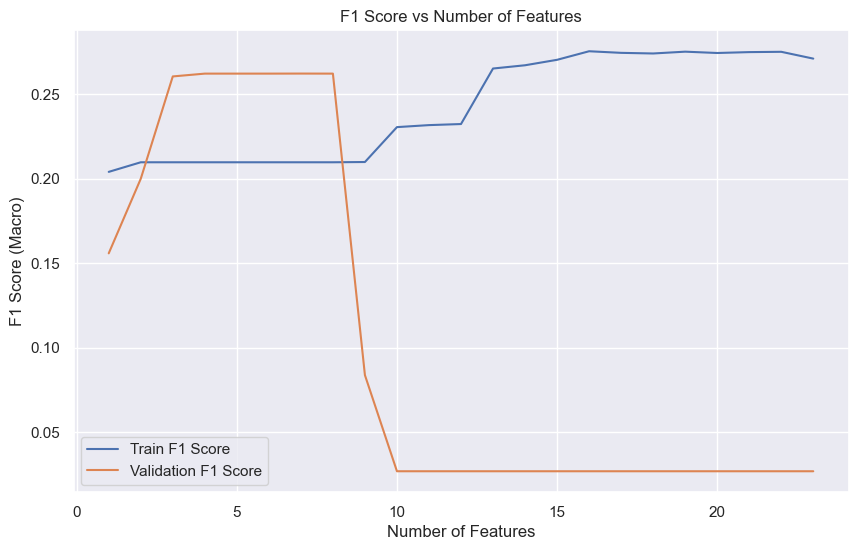

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(nof_list, train_f1score_list, label="Train F1 Score")
plt.plot(nof_list, val_f1score_list, label="Validation F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score (Macro)")
plt.title("F1 Score vs Number of Features")
plt.legend()
plt.show()

### RFE XGBoosting

In [14]:
# Adjust target variable classes to start from 0
y_preproc_train_adjusted = y_preproc_train - 1
y_preproc_val_adjusted = y_preproc_val - 1

#number of features
nof_list= np.arange(1, 24)            
high_score=0

#Variable to store the optimum features
nof=0           
train_f1score_list =[]
val_f1score_list = []

for n in range(len(nof_list)):
    
    #using XGBoost
    model = XGBClassifier() 
    
    rfe = RFECV(estimator = model,min_features_to_select = nof_list[n], step=1, cv=5)
    X_train_rfe = rfe.fit_transform(num_X_preproc_train[:40000],y_preproc_train_adjusted[:40000])
    X_val_rfe = rfe.transform(num_X_preproc_val[:40000])

    model.fit(X_train_rfe,y_preproc_train_adjusted[:40000])

    # Predictions for F1 score
    y_preproc_train_pred = model.predict(X_train_rfe)
    y_preproc_val_pred = model.predict(X_val_rfe)
    
    #storing results on training data
    train_f1score = f1_score(y_preproc_train_adjusted[:40000],y_preproc_train_pred[:40000], average='macro')
    train_f1score_list.append(train_f1score)
    
    #storing results on training data
    val_f1score = f1_score(y_preproc_val_adjusted[:40000],y_preproc_val_pred[:40000], average='macro')
    val_f1score_list.append(val_f1score)
    
    #check best score
    if(val_f1score >= high_score):
        high_score = val_f1score
        nof = nof_list[n]
        features_to_select = pd.Series(rfe.support_, index = num_X_preproc_train.columns)

        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")


Optimum number of features: 23
Score with 23 features: 0.227650
Features to select: 
Age at Injury                        True
Average Weekly Wage                  True
Birth Year                           True
Carrier Type                         True
IME-4 Count                          True
Industry Code                        True
Medical Fee Region                   True
WCIO Cause of Injury Code            True
WCIO Nature of Injury Code           True
WCIO Part Of Body Code               True
Number of Dependents                 True
Accident Year                        True
Agreement Reached                    True
Received_C2                          True
Received_C3                          True
Hearing_held                         True
Attorney/Representative_Y            True
COVID-19 Indicator_Y                 True
Alternative Dispute Resolution_N     True
Alternative Dispute Resolution_Y    False
Gender_F                             True
Gender_M                         

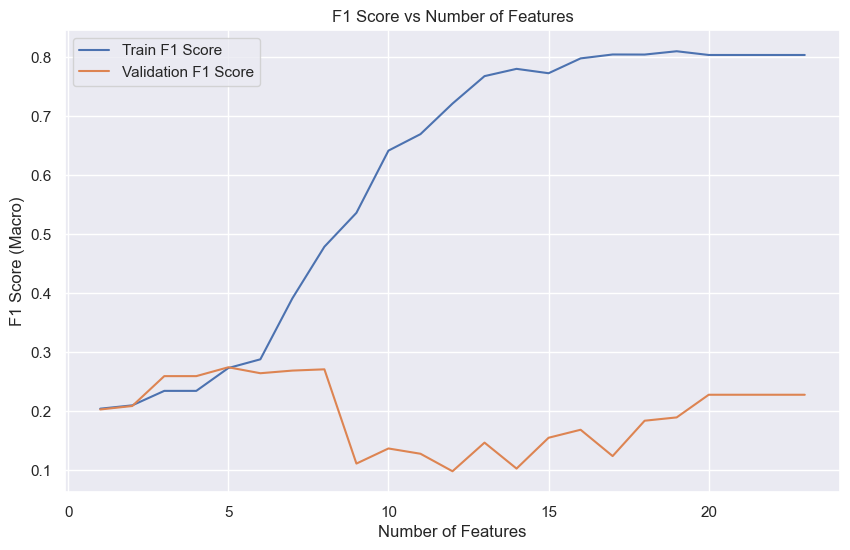

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(nof_list, train_f1score_list, label="Train F1 Score")
plt.plot(nof_list, val_f1score_list, label="Validation F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score (Macro)")
plt.title("F1 Score vs Number of Features")
plt.legend()
plt.show()

<a class="anchor" id="13th-bullet">

## Embedded Methods
    
</a>

<a class="anchor" id="14th-bullet">

### Lasso Regression
    
</a>

In [17]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [18]:
#
reg = LassoCV()

reg.fit(num_X_preproc_train, y_preproc_train)

coef = pd.Series(reg.coef_, index = num_X_preproc_train.columns)
coef

Age at Injury                       0.000000
Average Weekly Wage                 1.384313
Birth Year                         -0.000000
Carrier Type                       -0.000000
IME-4 Count                         0.067938
Industry Code                       0.000000
Medical Fee Region                 -0.000000
WCIO Cause of Injury Code           0.000000
WCIO Nature of Injury Code          0.000000
WCIO Part Of Body Code              0.000000
Number of Dependents               -0.000000
Accident Year                      -0.000000
Agreement Reached                   0.000000
Received_C2                         0.000000
Received_C3                         0.000000
Hearing_held                        0.000000
Attorney/Representative_Y           0.121441
COVID-19 Indicator_Y               -0.000000
Alternative Dispute Resolution_N    0.000000
Alternative Dispute Resolution_Y   -0.000000
Gender_F                           -0.000000
Gender_M                            0.000000
Gender_U  

In [19]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 20 variables


In [20]:
coef.sort_values()

Age at Injury                       0.000000
Gender_M                            0.000000
Gender_F                           -0.000000
Alternative Dispute Resolution_Y   -0.000000
Alternative Dispute Resolution_N    0.000000
COVID-19 Indicator_Y               -0.000000
Hearing_held                        0.000000
Received_C3                         0.000000
Received_C2                         0.000000
Agreement Reached                   0.000000
Gender_U                           -0.000000
Accident Year                      -0.000000
WCIO Part Of Body Code              0.000000
WCIO Nature of Injury Code          0.000000
WCIO Cause of Injury Code           0.000000
Medical Fee Region                 -0.000000
Industry Code                       0.000000
Carrier Type                       -0.000000
Birth Year                         -0.000000
Number of Dependents               -0.000000
Zip Code                            0.000004
IME-4 Count                         0.067938
Attorney/R

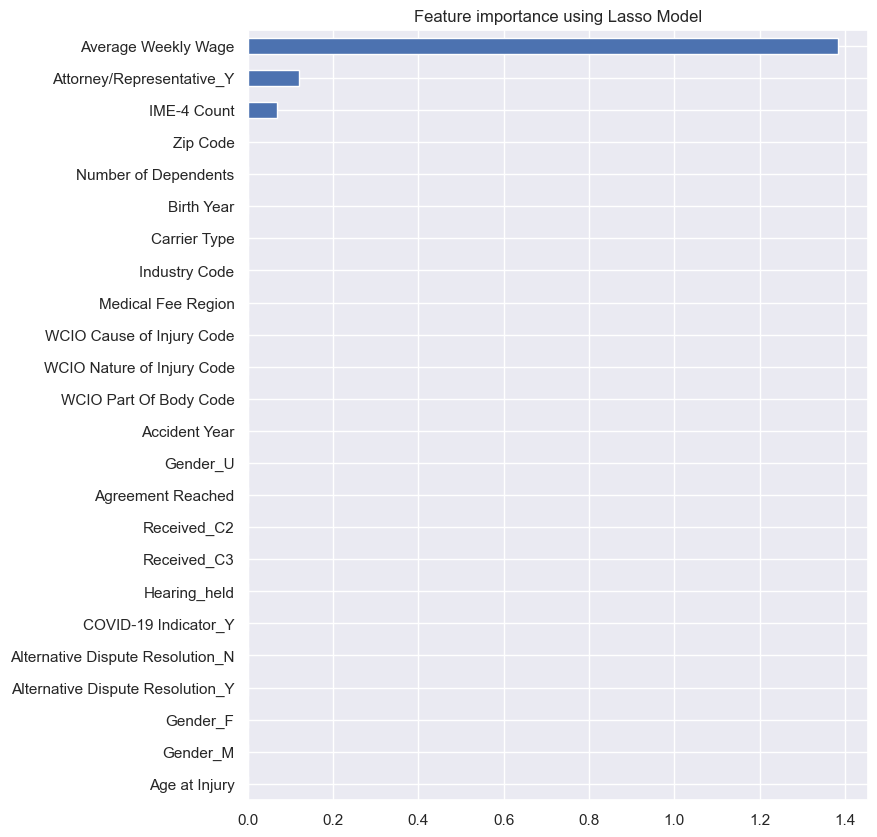

In [21]:
plot_importance(coef,'Lasso')

<a class="anchor" id="15th-bullet">

### Mutual Information Regressor
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SelectKBest.html
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.mutual_info_regression.html
</a>

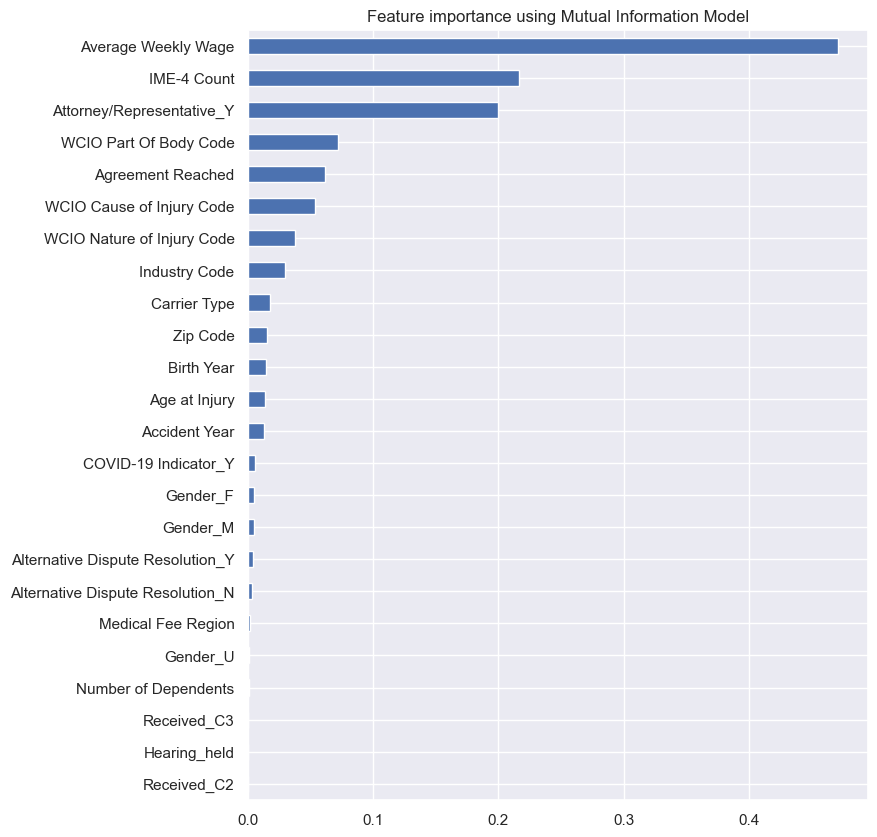

In [22]:
#  Mutual Information Regression for feature selection in regression problems 
mir = SelectKBest(score_func=mutual_info_regression, k= 'all')

# fit the model to the training data 
mir.fit(num_X_preproc_train, y_preproc_train)

# get the scores of the features
mir_scores = pd.Series(mir.scores_, index = num_X_preproc_train.columns)

# plot the scores
plot_importance(mir_scores,'Mutual Information')

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

### Numerical Data

| Predictor | Spearman | RFE LR | RFE XGB | Lasso | Mutual Information Reg. | What to do? | 
| --- | --- | --- | --- |--- |---|---|
| AgAge at Injurye | Keep | Keep | Keep |Keep | Keep | Include in the model |
| Gender_M | Keep | Keep | Keep |Keep| Keep | Include in the model |
| Gender_F | Keep| Discard | Discard |Keep ?| Keep |  Discard |
| Alternative Dispute Resolution_Y | Keep | Keep | Keep | Keep |Keep | Include in the model |
| Alternative Dispute Resolution_N | Keep? | Discard | Keep | Keep | Keep | Keep |
| COVID-19 Indicator_Y | Keep? | Discard | Discard | Keep | Keep | Discard |
| Hearing_held | Discard |Discard |Keep | Keep? |  Keep | Try with and without |
| Received_C3 | Discard |Discard |Keep | Keep? |  Keep | Try with and without |
| Received_C2 | Discard |Discard |Keep | Keep? |  Keep | Try with and without |
| Agreement Reached | Keep |Discard |Keep | Keep? |  Keep | Try with and without |
| Gender_U | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Accident Year | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| WCIO Part Of Body Code | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| WCIO Nature of Injury Code | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| WCIO Cause of Injury Code  | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Medical Fee Region | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Industry Code | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Carrier Type | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Birth Year | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Number of Dependents | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Zip Code | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| IME-4 Count  | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Attorney/Representative_Y | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Average Weekly Wage | Keep |Discard |Keep | Keep? | Keep |  Try with and without |


<hr>
### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| AgAge at Injurye | Keep | Keep | Keep |Keep | Include in the model |
| Gender_M | Keep | Keep | Keep |Keep| Include in the model |
| Gender_F | Keep?| Discard | Discard |Keep ?| Discard |
| Alternative Dispute Resolution_Y | Keep | Keep | Keep | Keep | Include in the model |
| Alternative Dispute Resolution_N | Keep? | Discard | Keep | Keep | Keep |
| COVID-19 Indicator_Y | Keep? | Discard | Discard | Keep | Discard |
| Hearing_held | Keep |Discard |Keep | Keep? |  Try with and without |
| Received_C3 | Keep |Discard |Keep | Keep? |  Try with and without |
| Received_C2 | Keep |Discard |Keep | Keep? |  Try with and without |
| Agreement Reached | Keep |Discard |Keep | Keep? |  Try with and without |
| Gender_U | Keep |Discard |Keep | Keep? |  Try with and without |
| Accident Year | Keep |Discard |Keep | Keep? |  Try with and without |
| WCIO Part Of Body Code | Keep |Discard |Keep | Keep? |  Try with and without |
| WCIO Nature of Injury Code | Keep |Discard |Keep | Keep? |  Try with and without |
| WCIO Cause of Injury Code  | Keep |Discard |Keep | Keep? |  Try with and without |
| Medical Fee Region | Keep |Discard |Keep | Keep? |  Try with and without |
| Industry Code | Keep |Discard |Keep | Keep? |  Try with and without |
| Carrier Type | Keep |Discard |Keep | Keep? |  Try with and without |
| Birth Year | Keep |Discard |Keep | Keep? |  Try with and without |
| Number of Dependents | Keep |Discard |Keep | Keep? |  Try with and without |
| Zip Code | Keep |Discard |Keep | Keep? |  Try with and without |
| IME-4 Count  | Keep |Discard |Keep | Keep? |  Try with and without |
| Attorney/Representative_Y | Keep |Discard |Keep | Keep? |  Try with and without |
| Average Weekly Wage | Keep |Discard |Keep | Keep? |  Try with and without |
<hr>
